<a href="https://colab.research.google.com/github/Adhira-Deogade/INFO-7374-Project---Style-transfer/blob/master/Exp8_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
up = files.upload()

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import imagenet_utils
from keras import backend as K
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, HTML
from IPython.display import display, Image
from functools import partial
import utils
from importlib import reload

from IPython.core.debugger import Tracer

import pprint
import time
from scipy.misc import imsave

%matplotlib inline

Using TensorFlow backend.


In [2]:
!ls

display_graph.py  Optimizer  __pycache__  sample_data  utils.py


In [3]:
!ls /tmp/nst

 1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
 89506247_children-lying-in-circle-on-grass_web.jpg
 children-couple-bgedit.png
 Children-playing-tug-of-war.jpg
 Green_Sea_Turtle_grazing_seagrass.jpg
 IMG_20170114_222025_931-58a01296a1b60__880.jpg
'photo-1524840127331-f2ca773ec28f?ixlib=rb-1.2.1'
 Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
 The_Great_Wave_off_Kanagawa.jpg
 Tuebingen_Neckarfront.jpg
 Vassily_Kandinsky,_1913_-_Composition_7.jpg


**Plot graphs**

In [0]:
from matplotlib.pyplot import imshow
from io import BytesIO
from IPython import display 
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np

In [0]:
def plot(img, scale=1, dpi=80):
  plt.figure(figsize=(img.shape[0]*scale/dpi, img.shape[1]*scale/dpi), dpi=dpi)
  imshow(img)

In [0]:
# plot("Vassily_Kandinsky,_1913_-_Composition_7.jpg")

Show image

In [0]:
def show(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a.astype('uint8')).save(f, fmt)
    img = display.Image(data=f.getvalue())
    display.display(img)

In [0]:
# show("/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg")

In [0]:
def resize_array(array, size):
    '''Resizes an image (formatted as np array) to give size.
    Args:
        array: np array representing the image.
        size: The desired size.
    Returns: The resized image as a float np array.
    '''
    image = PIL.Image.fromarray(array.astype('uint8').copy())
    image_resized = image.resize(size, PIL.Image.ANTIALIAS)
    return np.asarray(image_resized).astype(float)    


In [0]:
from display_graph import display_graph

In [0]:
# Output image size
image_size = (512, 512)

In [0]:
def load_image(size, filename=None):
    '''Load image from disc and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            filename: The fullpath to the image to load.
    '''
    width, height = size

    if not filename:
        raise ValueError(
            'If not generating random noise image, image filename is required.')
    # Load a picture
    img = PIL.Image.open(filename)
    img = img.resize((width, height))
    img_array = np.asarray(img.copy())
    return img_array

In [0]:
## Image laoding and generating

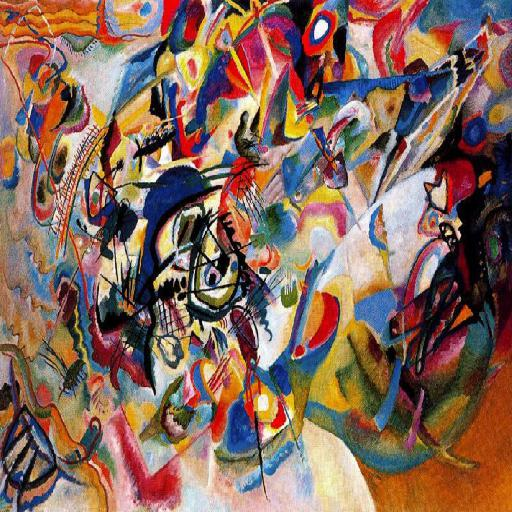

In [31]:
image = load_image(size=image_size, filename="/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg")
show(image)

In [0]:

graph = tf.Graph()
config = tf.ConfigProto()
# Uncomment this if you want to use two iPython scripts side by side,
# and you dont want tensorflow to take up all the GPU memory on initialization
# config.gpu_options.allow_growth=True

# Interactive session is better suited for notebooks
sess = tf.InteractiveSession(graph=graph, config=config)
K.set_session(sess)

# Keras flag - we are not training, just testing now
K.set_learning_phase(0)

In [0]:
def setup_model(initial_value, model_name='Inception5h'):
    '''Load the model. Use a TF tensor as input just for fun.
    Args: 
        initial_value: The initial value of the input tensor. Mainly used for size.
        model_name: Whether to normalize the input image.
    Returns:
        Tuple of (model, # The loaded keras model
            input_tensor, # The tensor that feeds the model
            content_layers, # The content layers of this model as tensors
            style_layers, # The style layers of this model as tensors
            preprocess_func, # Preprocesses an image for the model
            deprocess_func # Returns preprocessed image back to normal.
    '''
    # Prepare tensor for input image
    image_tensor = tf.Variable(initial_value)

    if model_name == 'VGG16' or model_name == 'VGG19':
        # These two models share a lot, so define them together
        if model_name == 'VGG16':
            # VGG 16 model
            model = VGG16(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)
        elif model_name == 'VGG19':
            model = VGG19(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)

        # Preprocesses an image for the model
        def preprocess_func(x):
            x = x.copy().astype(float)
            rank = len(x.shape)
            if (rank == 3):
                # Add extra batch dimension
                x = np.expand_dims(x, axis=0)
            x[:, :, :, 2] -= 103.939
            x[:, :, :, 1] -= 116.779
            x[:, :, :, 0] -= 123.68

            # Flip the channels from RGB to BGR
            x = x[:, :, :, ::-1]
            return x

        # Returns preprocessed image back to normal.
        def deprocess_func(x):
            x = np.asarray(x).copy()
            rank = len(x.shape)
            if (rank == 4):
                # Remove extra batch dimension
                x = np.squeeze(x, axis=0)

            # Flip the channels from BGR to RGB
            x = x[:, :, ::-1]

            # Remove zero-center by mean pixel
            x[:, :, 2] += 103.939
            x[:, :, 1] += 116.779
            x[:, :, 0] += 123.68

            x = np.clip(x, 0, 255).astype('uint8')
            return x

        # Define the style layers
        style_layers = [model.get_layer('block1_conv1').output,
                        model.get_layer('block2_conv1').output,
                        model.get_layer('block3_conv1').output,
                        model.get_layer('block4_conv1').output,
                        model.get_layer('block5_conv1').output]

        # Define the content layers
        content_layers = model.get_layer('block4_conv2').output

    # TODO: Add other models

    return model, image_tensor, content_layers, style_layers, preprocess_func, deprocess_func



In [39]:
with graph.as_default():
    with graph.name_scope("model") as scope:
        # Use the image size (with a batch dimension) to feed the model input.
        # We do so that the input has size and the convolutional layers
        # will be sized as well.
        initial = np.expand_dims(image, axis=0).astype('float32')

        # Setup the model
        (model, input_tensor, content_layers, style_layers,
         preprocess, deprocess) = setup_model(
            initial_value=initial,
            model_name='VGG19')

80142336/80134624 [==============================] - 6s 0us/step


In [40]:
# Checkout what we got
(model, input_tensor, content_layers, style_layers,
 preprocess, deprocess)

(<keras.engine.training.Model at 0x7f6311979470>,
 <tf.Variable 'model_3/Variable:0' shape=(1, 512, 512, 3) dtype=float32_ref>,
 <tf.Tensor 'model_3/block4_conv2/Relu:0' shape=(1, 64, 64, 512) dtype=float32>,
 [<tf.Tensor 'model_3/block1_conv1/Relu:0' shape=(1, 512, 512, 64) dtype=float32>,
  <tf.Tensor 'model_3/block2_conv1/Relu:0' shape=(1, 256, 256, 128) dtype=float32>,
  <tf.Tensor 'model_3/block3_conv1/Relu:0' shape=(1, 128, 128, 256) dtype=float32>,
  <tf.Tensor 'model_3/block4_conv1/Relu:0' shape=(1, 64, 64, 512) dtype=float32>,
  <tf.Tensor 'model_3/block5_conv1/Relu:0' shape=(1, 32, 32, 512) dtype=float32>],
 <function __main__.setup_model.<locals>.preprocess_func>,
 <function __main__.setup_model.<locals>.deprocess_func>)

In [42]:

# Summary of the model layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

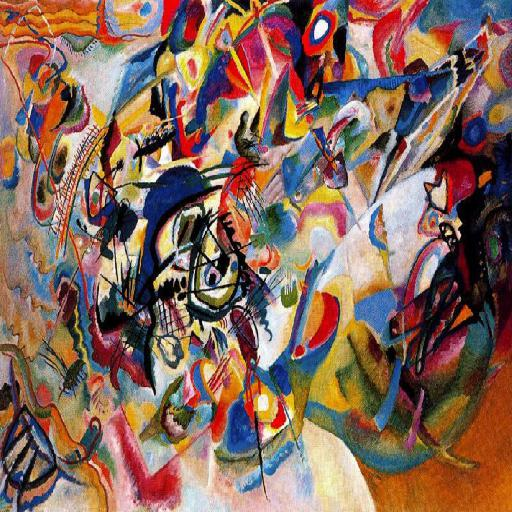

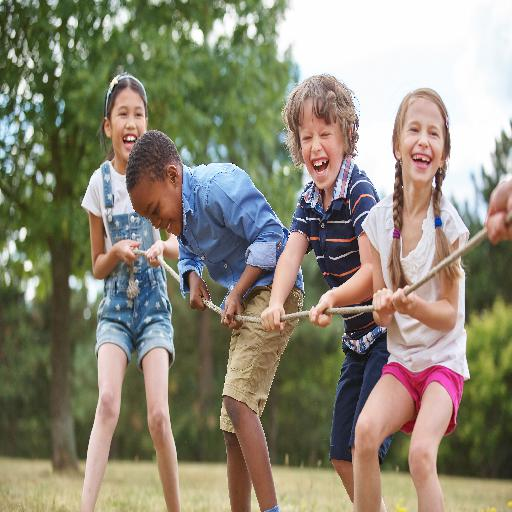

In [43]:
# Image which will define the style
style_image = load_image(size=image_size, filename="/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg")
show(style_image)

# Image to define the content
content_image = load_image(size=image_size, filename="/tmp/nst/Children-playing-tug-of-war.jpg")
show(content_image)

In [0]:

# Compute the style activations
style_layers_computed = sess.run(
    style_layers,
    feed_dict={input_tensor: preprocess(style_image)})

# Compute the content activations
content_layers_computed = sess.run(
    content_layers,
    feed_dict={input_tensor: preprocess(np.expand_dims(content_image, 0))})

In [0]:
def style_loss(current, computed):
    '''Define the style loss between a tensor and an np array.
    Args:
        current: tf.Tensor. The style activations of the current image.
        computed: np array. The style activations of the style input image.
    '''
    style_losses = []
    for layer1, layer2 in zip(current, computed):
        _, height, width, number = map(lambda i: i, layer2.shape)
        size = height * width * number

        # Compute layer1 Gram matrix
        feats1 = tf.reshape(layer1, (-1, number))
        layer1_gram = tf.matmul(tf.transpose(feats1), feats1) / size
        # Compute layer2 Gram matrix
        feats2 = tf.reshape(layer2, (-1, number))
        layer2_gram = tf.matmul(tf.transpose(feats2), feats2) / size

        dim1, dim2 = map(lambda i: i.value, layer1_gram.get_shape())
        loss = tf.sqrt(tf.reduce_sum(
            tf.square((layer1_gram - layer2_gram) / (number * number))))
        style_losses.append(loss)
    return tf.add_n(style_losses)

In [0]:

def content_loss(current, computed):
    # Currently only for a single layer
    _, height, width, number = computed.shape
    size = height * width * number
    return tf.sqrt(tf.nn.l2_loss(current - computed) / size)

In [0]:
def total_variation_loss(image, image_shape=None):
    if image_shape:
        width, height, channels = image_shape
    else:
        # Try to get the image size from the tensor
        dims = image.get_shape()
        width = dims[1].value
        height = dims[2].value
        channels = dims[3].value

    tv_x_size = width * (height - 1) * channels
    tv_y_size = (width - 1) * height * channels

    return (
        tf.reduce_sum(tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :])) +
        tf.reduce_sum(tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :]))
    )

In [0]:
def setup_gradient(input_tensor, result_tensor):
    '''Setup the gradient of the input tensor w.t.r 
    to the result tensor.
    Args: 
        input_tensor: The input features tensor.
        result_tensor: The tensor that we want to maximize.
    '''
    # First get the result tensor mean
    excitement_score = tf.reduce_mean(result_tensor)

    # Gradients give us how to change the input (input_tensor)
    # to increase the excitement_score.
    # We get the first result only since the model is designed to
    # work on batches, and we only use single image.
    gradient = tf.gradients(excitement_score, input_tensor)[0]

    # Normalize the gradient by its L2 norm.
    # Disabled for now.
    # gradient /= (tf.sqrt(tf.reduce_mean(tf.square(gradient)))
    #                            + 1e-5)

    return gradient, excitement_score

# How much content, style and total variance loss contribute to the
# total loss.
content_weight = 1e3
style_weight = 1e6
tv_weight = 1e-2  # 1e-3

# Set up the style, content, total variation, as well as total loss
# and use them to define the gradient.
with graph.as_default():
    with graph.name_scope("style_loss") as scope:
        style_loss_op = style_weight * \
            style_loss(style_layers, style_layers_computed)
    with graph.name_scope("content_loss") as scope:
        content_loss_op = content_weight * \
            content_loss(content_layers, content_layers_computed)
    with graph.name_scope("tv_loss") as scope:
        tv_loss_op = tv_weight * total_variation_loss(input_tensor)
    with graph.name_scope("loss") as scope:
        total_loss_op = style_loss_op + content_loss_op + tv_loss_op
    with graph.name_scope("gradient") as scope:
        gradient_op, score_op = setup_gradient(input_tensor, total_loss_op)

In [0]:
def get_uninitialized_variables(variables=None, session=None):
    """
    Get uninitialized variables in a session as a list.
        Args: 
            variables: list of tf.Variable. Get uninitiliazed vars 
                from these. If none, gets all uinitialized vars in session.
            session: tf.Session to find uninitialized vars in. If none
                uses default session.
        Returns:
            Uninitialized variables within `variables`.
            If `variables` not specified, return all uninitialized variables.
    """
    if not session:
        session = tf.get_default_session()
    if variables is None:
        variables = tf.global_variables()
    else:
        variables = list(variables)
    init_flag = session.run(
        tf.stack([tf.is_variable_initialized(v) for v in variables]))
    return [v for v, f in zip(variables, init_flag) if not f]


def initialize_variables():
    '''Initialize the internal variables the optimizer uses.
        We could do tf.global_variables_initializer().eval() to 
        initialize all variables but this messes up the keras model.'''
    # Get uninitialized vars and their initializers
    uninitialized_vars = get_uninitialized_variables()
    initializers = [var.initializer for var in uninitialized_vars]

    # Print uninitialized variables
    print('Uninitialized variables:')
    print([initializer.name for initializer in initializers])

    # Initialize the variables
    _ = [initializer.run() for initializer in initializers]


def init_input(show_image=False):
    ''' Define start image in the input tensor.
        The image we are going to start with is the content image, 
        with random petrubations (needed, otherwise TV loss converges to nan).
    Args:
        show_image: Whether to display the generated image.
    '''
    # Define random 0 to 1 image with size (batch_size, image_size, channels)
    #  mean=0.5, stddev=.5
    initial_random = tf.random_normal(
        mean=1, stddev=.01, shape=(1,) + image_size + (3,))

    # Use the content image
    initial_content = preprocess(np.expand_dims(content_image, axis=0))

    # Init the input tensor
    input_tensor.initializer.run()
    input_tensor.assign(
        tf.clip_by_value(initial_content * initial_random, 0, 255)
    ).eval()

    # Show the input tensor
    if show_image:
        show(np.squeeze(input_tensor.eval()))

# Helper to print the losses.


def print_progress(i,
                   iterations,
                   loss_computed,
                   style_loss_computed,
                   content_loss_computed,
                   tv_loss_computed):
    print('Iteration %d/%d Content L: %g Style L: %g TV L: %g Total L: %g' % (
        i,
        iterations,
        content_loss_computed,
        style_loss_computed,
        tv_loss_computed,
        loss_computed
    ))


def run_optimization(train_step, iterations=1000, print_n_times=10):
    ''' Run the optimization for a number of iterations. 
    Args:
        train_step: The op that gets executed every iteration.
        iterations: How many times to run the optimization. Recommended at
            least 500 - 1000 iterations for a good quality image. Good style
            should be visible even after 100 iters.
        print_n_times: Int, How many times to print the progress.
    Return:
        A list of losses during the optimization like so:
        [(time elapsed, loss)]
    '''
    if print_n_times == 0:
        # Dont print at all
        print_every_n = iterations + 1
    else:
        print_every_n = max(iterations // print_n_times, 1)

    # Keep only the image with the lowest loss
    # (in case we converge).
    best_loss = float('inf')
    best = None

    losses = []

    # To compute total optimization time
    start_time = time.time()

    # Optimization loop
    for i in range(iterations):
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
#         input_tensor.assign(tf.clip_by_value(input_tensor, 0, 255)).eval()

        # Run the training (train_step), and get the losses
        (_, result_image, loss_computed,
         style_loss_computed, content_loss_computed,
         tv_loss_computed) = sess.run(
            [train_step, input_tensor, score_op, style_loss_op, content_loss_op,
             tv_loss_op])

        wall_time = time.time() - start_time

        losses.append((wall_time, loss_computed))

        # Print progress
        if i % print_every_n == 0:
            print_progress(i, iterations, loss_computed,
                           style_loss_computed, content_loss_computed,
                           tv_loss_computed)

        # skip this for now.
        # if loss_computed < best_loss:
        #    best_loss = loss_computed
        #    best = result_image

    total_time = time.time() - start_time
    print ('Training took {:.0f} seconds or {:.2f} s/iteration !'.format(
        wall_time,
        wall_time / iterations))

    return losses


def optimize(optimizer, iterations=1000, new_image=True):
    ''' Define and run the optimization.
    Args:
        optimizer: The optimizer to use.
        iterations: Number of times to run optimizer.
        new_image: Whether to start with a new image, or continue with the 
            previous one.
    Return: A tuple: 
        A list of losses during the optimization like so: [(time elapsed, loss)]
        The image
    '''
    with graph.as_default():
        # Compute the gradients for a list of variables.
        grads_and_vars = optimizer.compute_gradients(score_op, [input_tensor])
        # Op that ask the optimizer to apply the gradients.
        train_step = optimizer.apply_gradients(grads_and_vars)

        initialize_variables()
        if new_image:
            init_input()
        losses = run_optimization(
            train_step, iterations=iterations, print_n_times=5)
        result_image = input_tensor.eval()
        result_image = np.clip(deprocess(result_image), 0, 255)
        show(result_image)
        return losses, result_image

In [0]:
def save_results(optimizer_name, loss=None, result_image=None):
    ''' A helper to save the results of this optimizer run.'''
    if result_image is not None:
        imageio.imwrite('results/{}.jpg'.format(optimizer_name), result_image)
    if loss is None:
        # Load the loss
        loss = np.loadtxt('results/' + optimizer_name + '.csv')
    else:
        # Save the loss
        loss = np.asarray(loss)
        np.savetxt('results/' + optimizer_name + '.csv', np.asarray(loss))
    plot, = plt.plot(loss[:, 0], loss[:, 1])
    plotHandles.append(plot)
    labels.append(optimizer_name)

In [0]:
# Turn interactive plotting off
plt.ioff()
# To display a legend in the plot
figure = plt.figure(figsize=(10, 10))
labels = []
plotHandles = []
# We are using a large learning rate to change the initial image sufficiently
learning_rate = 5

In [56]:
!pip install imageio

In [0]:
import imageio

Uninitialized variables:
[]
Iteration 0/1000 Content L: 291439 Style L: 6.1069e+06 TV L: 75066.1 Total L: 6.4734e+06
Iteration 200/1000 Content L: 399146 Style L: 1.00919e+06 TV L: 191346 Total L: 1.59968e+06
Iteration 400/1000 Content L: 384200 Style L: 838582 TV L: 181485 Total L: 1.40427e+06
Iteration 600/1000 Content L: 408998 Style L: 500267 TV L: 187304 Total L: 1.09657e+06
Iteration 800/1000 Content L: 392854 Style L: 665386 TV L: 179347 Total L: 1.23759e+06
Training took 139 seconds or 0.14 s/iteration !


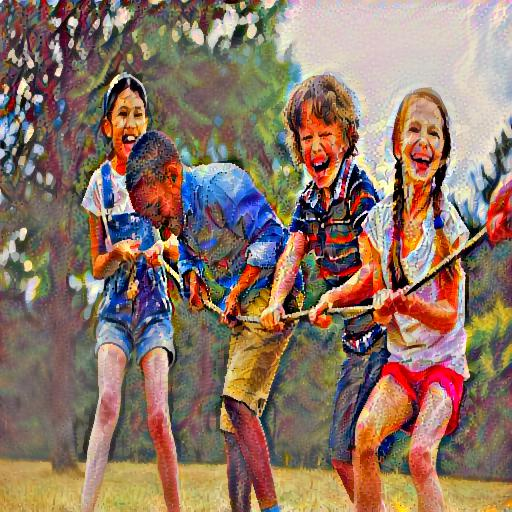

In [68]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

In [60]:
!pwd

/content


In [61]:
ls

display_graph.py  Optimizer/  __pycache__/  sample_data/  utils.py


In [0]:
mkdir results

Uninitialized variables:
['model_3/Variable/Adadelta_2/Assign', 'model_3/Variable/Adadelta_3/Assign']
Iteration 0/1000 Content L: 291495 Style L: 6.10705e+06 TV L: 75045.2 Total L: 6.47359e+06
Iteration 200/1000 Content L: 281198 Style L: 6.03033e+06 TV L: 77877.1 Total L: 6.3894e+06
Iteration 400/1000 Content L: 281142 Style L: 5.90829e+06 TV L: 82910.8 Total L: 6.27234e+06
Iteration 600/1000 Content L: 297291 Style L: 5.6949e+06 TV L: 90861.2 Total L: 6.08305e+06
Iteration 800/1000 Content L: 362068 Style L: 5.26776e+06 TV L: 102582 Total L: 5.73241e+06
Training took 140 seconds or 0.14 s/iteration !


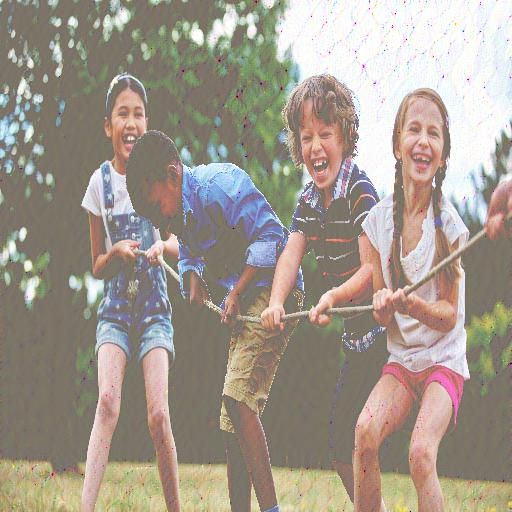

In [69]:

optimizer = tf.train.AdadeltaOptimizer(learning_rate=5)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
['model_3/Variable/Adagrad/Assign']
Iteration 0/1000 Content L: 291463 Style L: 6.10727e+06 TV L: 75030.5 Total L: 6.47376e+06
Iteration 200/1000 Content L: 438009 Style L: 783283 TV L: 213287 Total L: 1.43458e+06
Iteration 400/1000 Content L: 436034 Style L: 605275 TV L: 206994 Total L: 1.2483e+06
Iteration 600/1000 Content L: 432860 Style L: 515556 TV L: 201900 Total L: 1.15032e+06
Iteration 800/1000 Content L: 431209 Style L: 454443 TV L: 197914 Total L: 1.08357e+06
Training took 137 seconds or 0.14 s/iteration !


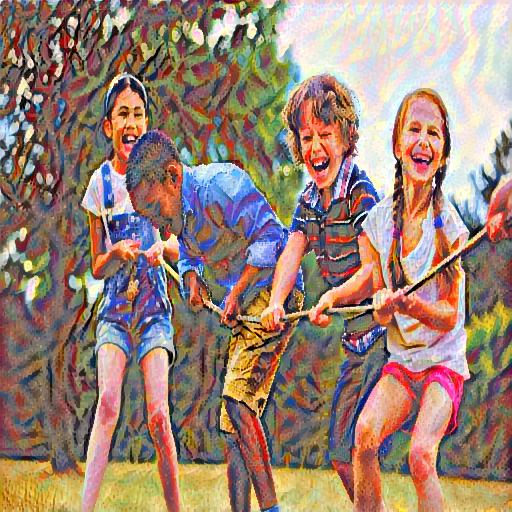

In [70]:

optimizer = tf.train.AdagradOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
['beta1_power/Assign', 'beta2_power/Assign', 'model_3/Variable/Adam/Assign', 'model_3/Variable/Adam_1/Assign']
Iteration 0/1000 Content L: 291447 Style L: 6.10714e+06 TV L: 75038.7 Total L: 6.47363e+06
Iteration 200/1000 Content L: 416567 Style L: 216789 TV L: 181300 Total L: 814656
Iteration 400/1000 Content L: 408279 Style L: 170891 TV L: 166827 Total L: 745998
Iteration 600/1000 Content L: 401536 Style L: 152548 TV L: 160403 Total L: 714486
Iteration 800/1000 Content L: 403183 Style L: 147067 TV L: 158220 Total L: 708470
Training took 143 seconds or 0.14 s/iteration !


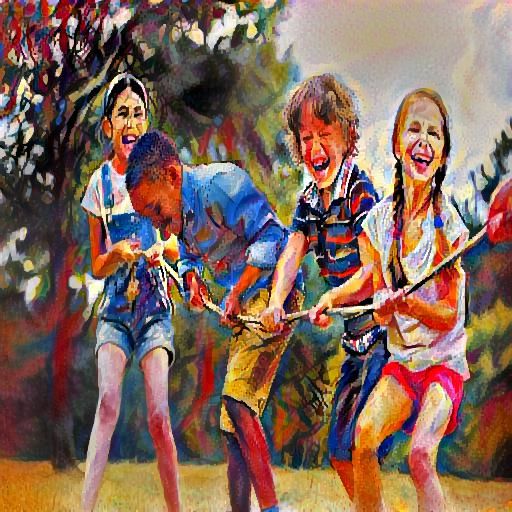

In [71]:
optimizer = tf.train.AdamOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
['model_3/Variable/RMSProp/Assign', 'model_3/Variable/RMSProp_1/Assign']
Iteration 0/1000 Content L: 291478 Style L: 6.10693e+06 TV L: 75039.4 Total L: 6.47345e+06
Iteration 200/1000 Content L: 426919 Style L: 905801 TV L: 218721 Total L: 1.55144e+06
Iteration 400/1000 Content L: 437668 Style L: 599984 TV L: 219840 Total L: 1.25749e+06
Iteration 600/1000 Content L: 440679 Style L: 910835 TV L: 207367 Total L: 1.55888e+06
Iteration 800/1000 Content L: 436572 Style L: 785133 TV L: 210390 Total L: 1.4321e+06
Training took 143 seconds or 0.14 s/iteration !


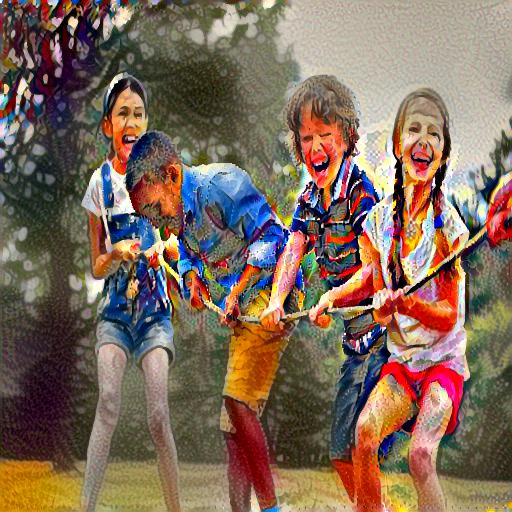

In [72]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 649895.062500
  Number of iterations: 1000
  Number of functions evaluations: 1014


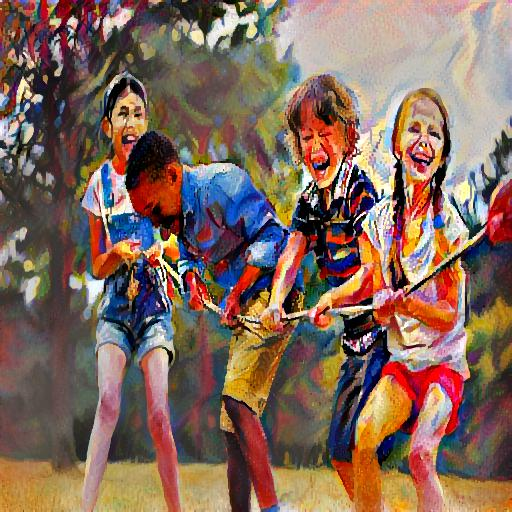

In [73]:
with graph.as_default():
    init_input()
    iterations = 1000
    
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
        score_op,
        var_list=[input_tensor],
        options={'maxiter': iterations})

    def step_callback(x):
        pass
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
#         x = x.astype('float32').reshape((1,) + image_size + (3,))
#         x = input_tensor.assign(tf.clip_by_value(x, 0, 255)).eval()
        # Show the image at this iteration
        # show(np.reshape(x, image_size + (3,)))

    def loss_callback(*args):
        wall_time = time.time() - start_time
        losses.append((wall_time, args[0]))

    losses = []
    start_time = time.time()

    optimizer.minimize(
        sess,
        #         feed_dict=[input_tensor],
        fetches=[score_op, style_loss_op, content_loss_op, tv_loss_op],
        step_callback=step_callback,
        loss_callback=loss_callback
    )

    result_image = input_tensor.eval()
    result_image = np.clip(deprocess(result_image), 0, 255)
    show(result_image)
    save_results('L-BFGS', losses, result_image)


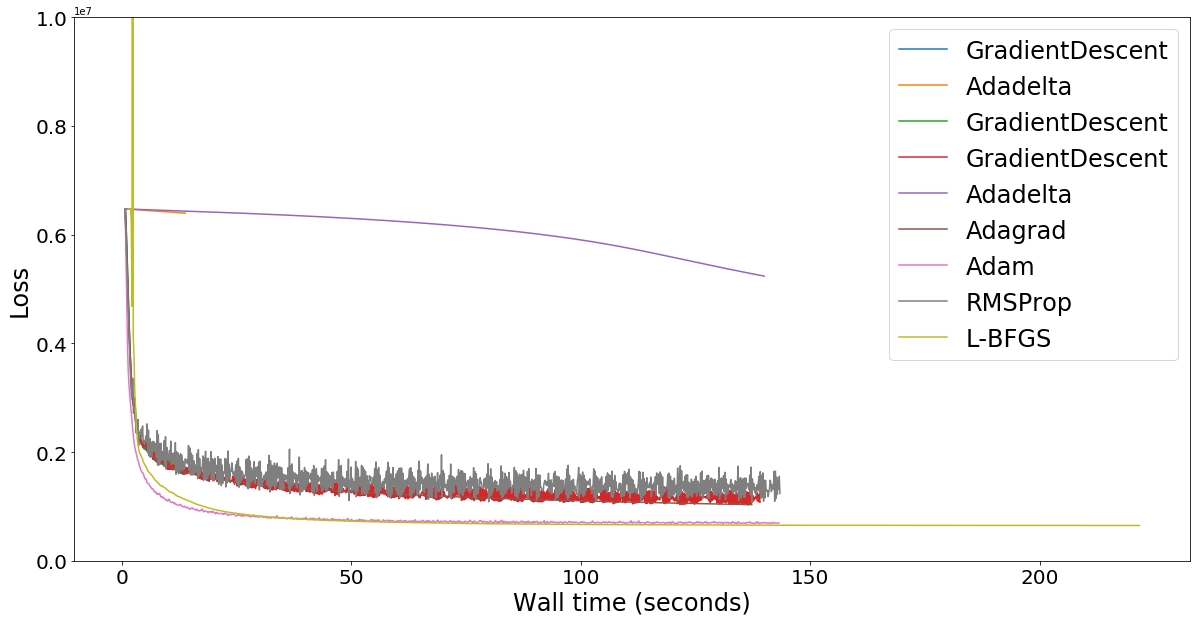

In [74]:
figure.set_size_inches(20, 10, forward=True)
plt.legend(plotHandles, labels, prop={'size': 24})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tick_params(labelsize=20)
plt.xlabel('Wall time (seconds)', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.ylim([0, 1e+7])

figure